## Import functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import sklearn
import pypfopt
import itertools
import pypfopt
import cvxpy as cp
from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.covariance import LedoitWolf

## Data preparation

In [2]:
df = pd.read_csv('Test_data/48_Industry_Portfolios_Daily_Clean.csv', index_col = 0)
df.rename(columns={"Average Value Weighted Returns -- Daily": "date"}, inplace=True)
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
df = df.loc[(df['date'] >= '1992-12-31') & (df['date'] <= '2022-12-31')]
df = df.set_index('date')
df = df/100
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7556 entries, 1992-12-31 to 2022-12-30
Data columns (total 48 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0    Agric  7556 non-null   float64
 1   Food    7556 non-null   float64
 2   Soda    7556 non-null   float64
 3   Beer    7556 non-null   float64
 4   Smoke   7556 non-null   float64
 5   Toys    7556 non-null   float64
 6   Fun     7556 non-null   float64
 7   Books   7556 non-null   float64
 8   Hshld   7556 non-null   float64
 9   Clths   7556 non-null   float64
 10  Hlth    7556 non-null   float64
 11  MedEq   7556 non-null   float64
 12  Drugs   7556 non-null   float64
 13  Chems   7556 non-null   float64
 14  Rubbr   7556 non-null   float64
 15  Txtls   7556 non-null   float64
 16  BldMt   7556 non-null   float64
 17  Cnstr   7556 non-null   float64
 18  Steel   7556 non-null   float64
 19  FabPr   7556 non-null   float64
 20  Mach    7556 non-null   float64
 21  ElcEq   7556 non-nu

## Portfolio Seperation N * T matrix 
T observations on a system of N variables representing T returns on a universe of N stocks 

(N = 48 assets in each portfolio; T = 250 observation days， P = 21 observation days, portfolios_set = 347)

In [3]:
observation_days = 250
prediction_days = 21
n_assets = df.shape[1]
n_portfolios = math.floor((len(df)-250)/21)
n_portfolios

347

In [4]:
def get_all_portfoios(obs_days,pre_days,n):
    obs_data = []
    pre_data = []
    for i in range(0,n):
        obs_data.append(df.iloc[pre_days*i:obs_days + pre_days*i,:])
        pre_data.append(df.iloc[obs_days+pre_days*i:obs_days+pre_days*i+pre_days:,:])
    return obs_data, pre_data

In [5]:
obs_group, pre_group = get_all_portfoios(observation_days, prediction_days, n_portfolios)
print(f"number of observation: {len(obs_group)}\n number of prediction {len(pre_group)}\n shape of observation:{obs_group[0].shape}\n shape of prediction:{pre_group[0].shape}\n\n observation sample \n{obs_group[0]}\")")

number of observation: 347
 number of prediction 347
 shape of observation:(250, 48)
 shape of prediction:(21, 48)

 observation sample 
             Agric   Food    Soda    Beer    Smoke   Toys    Fun     Books  \
date                                                                         
1992-12-31  0.0111 -0.0081  0.0037 -0.0158  0.0037  0.0027 -0.0035 -0.0026   
1993-01-04 -0.0020 -0.0079 -0.0048 -0.0019 -0.0071  0.0027 -0.0027  0.0041   
1993-01-05 -0.0025 -0.0143 -0.0146 -0.0140 -0.0133  0.0052  0.0026 -0.0005   
1993-01-06  0.0074 -0.0097  0.0139 -0.0009 -0.0306  0.0083  0.0137  0.0081   
1993-01-07 -0.0203 -0.0060 -0.0089 -0.0196  0.0013 -0.0134 -0.0095 -0.0036   
...            ...     ...     ...     ...     ...     ...     ...     ...   
1993-12-20 -0.0072 -0.0024 -0.0125  0.0026 -0.0046 -0.0113 -0.0027  0.0009   
1993-12-21 -0.0081  0.0030 -0.0029  0.0073  0.0094 -0.0187 -0.0063 -0.0021   
1993-12-22 -0.0035  0.0047  0.0348  0.0090  0.0072  0.0069  0.0071  0.0044   
1993-

## Compare 6 models to improve the out-of-sample performance
### Minimum-variance portfolio (MVP)

In [6]:
class Models:
    def __init__(self, obs_returns, pre_returns, model):
        self.obs_returns = obs_returns
        self.pre_returns = pre_returns
        self.model = model
        
        '''
        "Navie":
        "1/N": stands for equally-weighted (1/N) portfolio
        "MINC": stands for minimum-variance portfolio with shortsales constrained
        "LW1F": L1-regularization plus shrinking the sample covariance matrix towards a one-factor matrix
        "LCC1": stands for L1-regularization plus the constant correlation model
        "LCC2": stands for L1-regularization plus a fifty-fifty combination of the constant correlation model 
            and the sample pair-wise correlations
        '''
    
    def optimal_weights(self):
        weights = []
        expected_return = []
        volatility = []
        sharpe_ratio = []
        for i in range(len(self.obs_returns)):
            mu = pypfopt.expected_returns.mean_historical_return(self.obs_returns[i], returns_data=True, 
                                                    compounding=False, frequency=250, log_returns=False)
            if self.model == 'Navie':
                cov = pypfopt.risk_models.sample_cov(self.obs_returns[i], returns_data=True,
                                                     frequency=250, log_returns=False)  # no shrinkage
                S = pypfopt.risk_models.fix_nonpositive_semidefinite(cov, fix_method='spectral')
                ef = EfficientFrontier(mu, S, weight_bounds=(-1,1)) # naive - short sales allowed
                
            if self.model == '1/N':
                cov = pypfopt.risk_models.sample_cov(self.obs_returns[i], returns_data=True,
                                                 frequency=250, log_returns=False) # no shrinkage
                S = pypfopt.risk_models.fix_nonpositive_semidefinite(cov, fix_method='spectral')
                ef = EfficientFrontier(mu, S, weight_bounds=(1/48, 1/48)) # naive - short sales allowed
                
            if self.model == 'MINC':
                cov = pypfopt.risk_models.sample_cov(self.obs_returns[i], returns_data=True,
                                                 frequency=250, log_returns=False) # no shrinkage
                S = pypfopt.risk_models.fix_nonpositive_semidefinite(cov, fix_method='spectral')
                ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
                
            if self.model == 'LM1F':
                cov = pypfopt.risk_models.CovarianceShrinkage(self.obs_returns[i], returns_data=True, 
                                                              frequency=250, log_returns=False)
                S = cov.ledoit_wolf(shrinkage_target='single_factor')
                ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
            
            if self.model == 'LCC1':
                def L1_norm(w, k=1):
                    return k * cp.norm(w, 1)
                def new_objective(w):
                    return L1_norm(w, k=2)
                cov = pypfopt.risk_models.CovarianceShrinkage(self.obs_returns[i], returns_data=True, 
                                                          frequency=250, log_returns=False).ledoit_wolf(shrinkage_target='constant_correlation')
                ef = EfficientFrontier(mu, cov, weight_bounds=(0, 1))
                ef.add_objective(new_objective)
   
            if self.model == 'LCC2':
                def L1_norm(w, k=1):
                    return k * cp.norm(w, 1)
                cov = pypfopt.risk_models.sample_cov(self.obs_returns[i],returns_data=True,frequency=250, log_returns=False)
                cov2 = pypfopt.risk_models.CovarianceShrinkage(self.obs_returns[i], returns_data=True, 
                                                              frequency=250, log_returns=False).ledoit_wolf(shrinkage_target='constant_correlation')
                S = 1/2 * cov + 1/2 * cov2
                ef = EfficientFrontier(mu, S, weight_bounds=(0,1))
                ef.add_objective(L1_norm, k=2)
                
            raw_weights = ef.min_volatility()
            cleaned_weights = ef.clean_weights()
            weights.append(np.array(list(cleaned_weights.values())))
            performance = ef.portfolio_performance(verbose=False)
            np.array(expected_return.append(performance[0]))
            np.array(volatility.append(performance[1]))
            np.array(sharpe_ratio.append(performance[2]))
        return weights, expected_return, volatility, sharpe_ratio
    
    def optimal_portfolio(self, optimal_weights):
        variance = []
        sharpe_ratio = []
        for i in range(len(self.pre_returns)):
            mu = pypfopt.expected_returns.mean_historical_return(self.pre_returns[i], returns_data=True, 
                                                    compounding=False, frequency=21, log_returns=False)
            if self.model == 'Navie':
                cov = pypfopt.risk_models.sample_cov(self.pre_returns[i], returns_data=True, 
                                                     frequency=21, log_returns=False)
                S = pypfopt.risk_models.fix_nonpositive_semidefinite(cov, fix_method='spectral')

            if self.model == '1/N':
                cov = pypfopt.risk_models.sample_cov(self.pre_returns[i], returns_data=True,
                                                     frequency=21, log_returns=False)
                S = pypfopt.risk_models.fix_nonpositive_semidefinite(cov, fix_method='spectral')
                
            if self.model == 'MINC':
                cov = pypfopt.risk_models.sample_cov(self.pre_returns[i], returns_data=True,
                                                     frequency=21, log_returns=False)
                S = pypfopt.risk_models.fix_nonpositive_semidefinite(cov, fix_method='spectral')
                
            if self.model == 'LM1F':
                cov = pypfopt.risk_models.CovarianceShrinkage(self.pre_returns[i], returns_data=True, 
                                                              frequency=21, log_returns=False)
                S = cov.ledoit_wolf(shrinkage_target='single_factor')
            
            if self.model == 'LCC1':
                cov = pypfopt.risk_models.CovarianceShrinkage(self.pre_returns[i], returns_data=True, 
                                                              frequency=21, log_returns=False)
                S = cov.ledoit_wolf(shrinkage_target='constant_correlation')
   
            if self.model == 'LCC2':
                cov = pypfopt.risk_models.sample_cov(self.obs_returns[i],returns_data=True,frequency=21, log_returns=False)
                cov2 = pypfopt.risk_models.CovarianceShrinkage(self.obs_returns[i], returns_data=True, 
                                                              frequency=21, log_returns=False).ledoit_wolf(shrinkage_target='constant_correlation')
                S = 1/2 * cov + 1/2 * cov2
            
            sharpe_ratio.append(pypfopt.objective_functions.sharpe_ratio(optimal_weights[i], mu, S))
            variance.append(pypfopt.objective_functions.portfolio_variance(optimal_weights[i], S))
        return variance, sharpe_ratio

    def ave_parameters(self, variance_pre,sharpe_ratio_pre):
        var = np.sum(variance_pre)/len(variance_pre)
        sharpe_ratio = np.sum(sharpe_ratio_pre)/len(sharpe_ratio_pre)
        return var, sharpe_ratio

In [7]:
m = Models(obs_group, pre_group, 'LCC1')
w = m.optimal_weights()[0]
variance_pre, sharpe_ratio_pre = m.optimal_portfolio(w)
print(variance_pre, sharpe_ratio_pre)

[0.00016222079590341316, 0.0008423853007168936, 0.0003897756474566706, 0.0016328577232181463, 0.00062524864699211, 0.0005000807277754501, 0.00022363811032642127, 0.0003000274931169444, 0.00038250557508677795, 0.00044324000490716687, 0.0005636468802191882, 0.0004946751439194618, 0.00027143580427030914, 0.00019801998278053508, 0.0003233169885640591, 0.00020944044544327602, 0.0003263480802306927, 0.000487251241692834, 0.0005046999488020883, 0.00016641923900168976, 0.00015032894292692022, 0.00019564413306837346, 0.0003780867471432958, 0.0004891138800596949, 0.0004692588536690553, 0.0004675205240538403, 0.0010096992108746638, 0.0005360122361538493, 0.000556283049149853, 0.00035051061551520695, 0.0014818420005528344, 0.0006724939875189322, 0.00033785475114794404, 0.0002206527658303694, 0.0002415323672328525, 0.0006227011588068332, 0.0003691367643048228, 0.0004872739320509901, 0.0004016912075696638, 0.0008681007994902588, 0.001008814249123438, 0.00043444055692077596, 0.0005358190691547014, 0.

### Compare results by model

In [8]:
model_list = ['Navie','1/N','MINC','LM1F','LCC1','LCC2']
results = []
ave_results = []
for m in model_list:
    m = Models(obs_group, pre_group, m)
    w = m.optimal_weights()[0]
    variance, sharpe_ratio_ = m.optimal_portfolio(w)
    var, sharpe_ratio = m.ave_parameters(variance,sharpe_ratio_)
    results.append(
        {
            'var':variance,
            'sharpe_ratio': sharpe_ratio_
            })
    ave_results.append(
        {
            'ave_var':var,
            'ave_sharpe_ratio': sharpe_ratio
            })
results = pd.DataFrame(results)
results.index = model_list
ave_results = pd.DataFrame(ave_results)
ave_results.index = model_list

/root/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pypfopt/risk_models.py:68: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
/root/.pyenv/versions/3.10.6/lib/python3.10/site-packages/pypfopt/risk_models.py:87: UserWarning: Could not fix matrix. Please try a different risk model.
  warnings.warn(


In [9]:
results

,var,sharpe_ratio
Navie,"[6.426962293709353e-05, 0.0006951721827465479,...","[4.955999884043957, 1.3019781635064123, 0.2827..."
1/N,"[0.00018703813516526445, 0.0009753010609462544...","[-0.21513025900602212, 0.7722111549827296, 0.8..."
MINC,"[9.33382642813858e-05, 0.0007303987426421992, ...","[2.7454263496263307, 1.3616906118123084, 0.446..."
LM1F,"[0.00011894754745794725, 0.0007365484359727937...","[2.1208457210857308, 1.2631741061038064, 0.471..."
LCC1,"[0.00016222079590341316, 0.0008423853007168936...","[1.8868100280702924, 1.1977865945956483, 0.430..."
LCC2,"[0.00029323123687525224, 0.0002835026427714589...","[1.47262812323167, 2.126873223628827, 0.502894..."


In [10]:
ave_results

,ave_var,ave_sharpe_ratio
Navie,0.001202,0.389220
1/N,0.002938,0.138400
MINC,0.001430,0.312059
LM1F,0.001314,0.328086
LCC1,0.001517,0.302290
LCC2,0.001188,0.446178


In [11]:
var_plot = results["var"].apply(pd.Series).T
sharpe_ratio_plot = results["sharpe_ratio"].apply(pd.Series).T

In [12]:
var_plot

,Navie,1/N,MINC,LM1F,LCC1,LCC2
0,0.000064,0.000187,0.000093,0.000119,0.000162,0.000293
1,0.000695,0.000975,0.000730,0.000737,0.000842,0.000284
2,0.000391,0.000443,0.000349,0.000353,0.000390,0.000280
3,0.001207,0.002161,0.001475,0.001438,0.001633,0.000270
4,0.000339,0.000686,0.000557,0.000512,0.000625,0.000358
...,...,...,...,...,...,...
342,0.000856,0.002734,0.000860,0.000695,0.001002,0.001335
343,0.001892,0.003371,0.001737,0.001473,0.001710,0.001359
344,0.003558,0.007506,0.004046,0.003666,0.004112,0.001440
345,0.002890,0.005348,0.003231,0.003003,0.003511,0.001670


## Visualization

<AxesSubplot:>

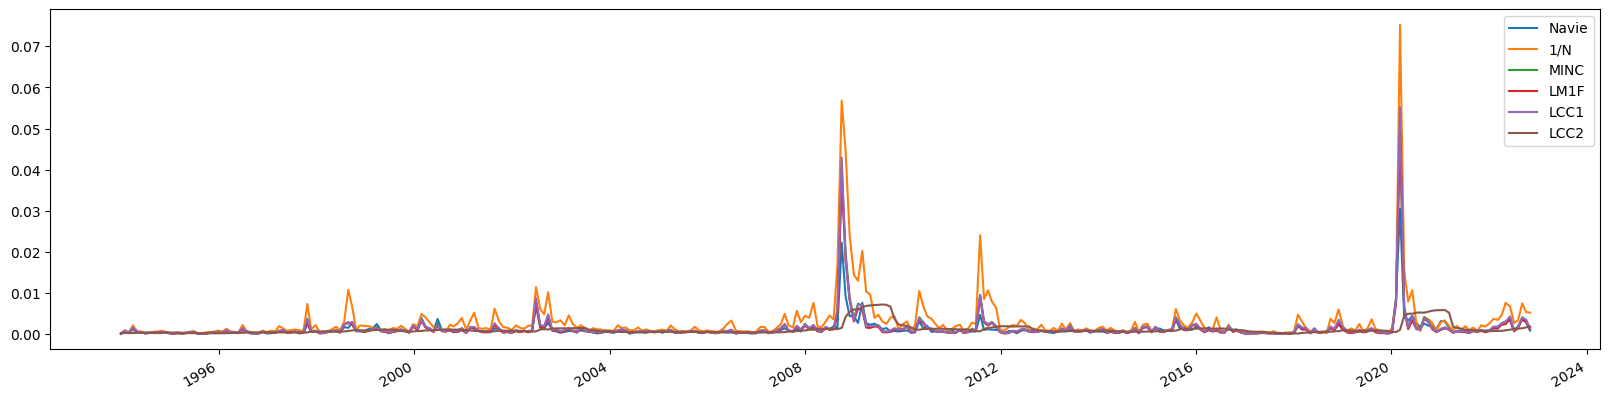

In [13]:
date = list(df.index)[250::21][:-1]
var_plot.index = date
var_plot.plot(figsize=(20,5))

<AxesSubplot:>

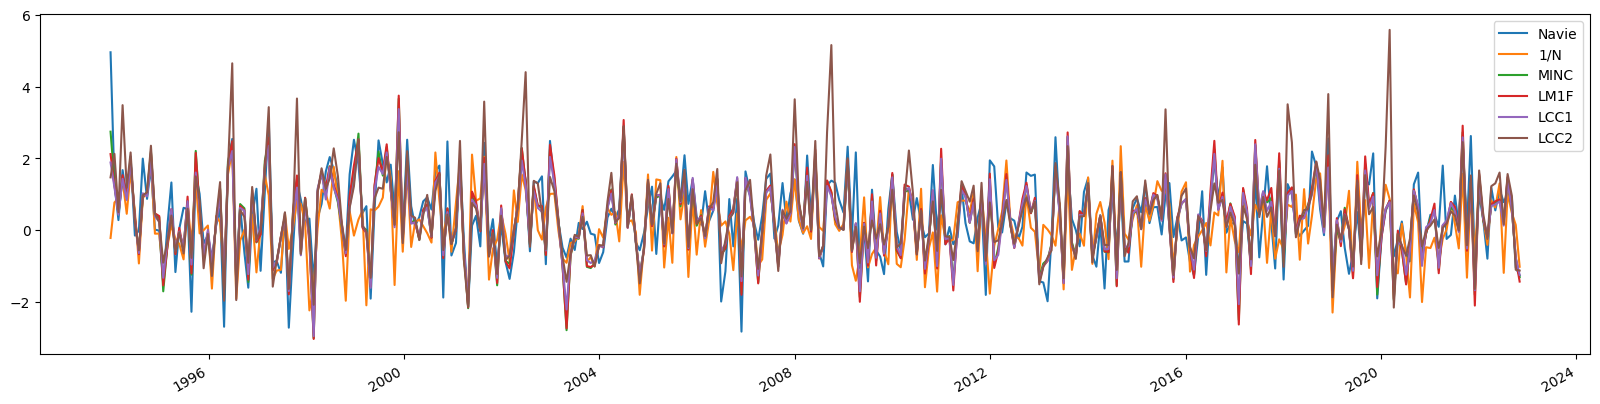

In [14]:
sharpe_ratio_plot.index = date
sharpe_ratio_plot.plot(figsize=(20,5))